# 제주도 버스승차 인원 예측
- ## data 415423 rows × 49 columns
### Columns
- id : 해당 데이터에서의 고유한 id
- data : 날짜
- bus_route_id : 노선 ID
- in_out : 시내버스, 시외버스 구분
- station_code : 해당 승하차 정류소의 id
- station_name : 해당 승하차 정류소의 이름
- latitude : 해당 버스정류장의 위도
- longitude : 해당 버스정류장의 경도
- X-Y_ride : X:00:00 ~ x:59:59까지 승차한 인원 수
- X-Y_takeoff : X:00:00 ~ x:59:59까지 하차한 인원 수
- 18-20_ride : 18:00:00부터 19:59:59까지 승차한 인원 수
- 지번주소 : EDA 및 제주 날씨 merge용 column 
- si :EDA 및 제주 날씨 merge용 column 
- city : EDA 및 제주 날씨 merge용 column  
- dong : EDA 및 제주 날씨 merge용 column  
- road_addr : EDA 및 제주 날씨 merge용 column  
- weather_addr : EDA 및 제주 날씨 merge용 column 
- temperature : 온도
- precipitation : 강수량
- bus_interval : 노선 배차 간격
- date_day : 일 (1일 ~ 30일)
- date_dayofweek : 요일 (0 ~ 6)
- date_dayofname : 요일 (월 ~ 일)
- weekday : 평일 여부
- weekend : 주말 여부
- holiday : 공휴일 여부
- typhoon : 태풍이 온날
- in_ : 시내 버스 구분
- out : 시외 버스 구분
- ridexx : ride(탑승)의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- offxx : off(하차)의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- ride_sum : 승차인원의 합계
- off_sum : 하차인원의 합계
- bus_route_id_sum : 정류소, 일별 운행한 버스노선의 갯수
- bus_route_id_all_sum : 정류소별 9월 전체 운행한 버스노선의 갯수



### 0. 공통

In [2]:
# 추가되는 패키지는 여기에서 import 해주세요
import warnings
warnings.filterwarnings('ignore')
import missingno
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pickle
from sklearn.externals import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from itertools import count
import plotly.express as px

import geopy.distance

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
# matplotlib 설정
mpl.use('Agg')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
pd.set_option('max_columns', 700)
pd.set_option('max_rows', 500)

### 01. 데이터 전처리 부분 (컬럼 추가, 삭제 등)

In [ ]:
# 데이터 load
train = pd.read_csv('train.csv',date_parser='date')
train.tail(2)

In [ ]:
# 분석을 위해 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)
train.tail(2)

In [ ]:
coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도
train['dis_jejusi'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusi).km for i in range(len(train))]
train['dis_seoquipo'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(train))]

def get_station_across():
    
    d2 = train
#     d2 = train.loc[300000:len(train)] ## 데이터 확인용 
    blank = pd.DataFrame()
    
    for i in d2.index:
#         print(str(i)+"/"+ str(len(d2)))
        test = d2.loc[i]
        test_date = d2.loc[i, 'date']
        test_st_name = d2.loc[i, 'station_name']
        test_dis = d2.loc[i, 'dis_jejusi']       
        

        right = d2.query('date == @test_date & station_name == @test_st_name').reset_index()
        right['code'] = abs(right['station_code'] - d2.loc[i, 'station_code'])
        right['standard'] = abs(right['dis_jejusi'] - d2.loc[i, 'dis_jejusi'])
        right['route_id'] = abs(right['bus_route_id'] - d2.loc[i, 'bus_route_id'])

        bag = pd.DataFrame(np.zeros(len(right.columns))).T #26
        bag.columns = right.columns
        bag.station_name = right.station_name
        bag.station_code = right.station_code
        bag.date = right.date
        bag.in_out = right.in_out
        bag.bus_route_id = right.bus_route_id

        
        try:
            A = pd.DataFrame(test).T.merge(pd.DataFrame(right.sort_values(['route_id','code','standard']).reset_index(drop = True).loc[1]).T, on = 'station_name')
        except:
            A = pd.DataFrame(test).T.merge(bag, on = 'station_name')
        
        blank = pd.concat([blank, A])
    blank.drop(['code','standard','index','id_y'], axis = 1, inplace = True)
    blank.reset_index(inplace = True)
    return blank

In [4]:
# train = get_station_across()
train = pd.read_csv('trainx2.csv')
train.drop(train.columns[0], axis = 1, inplace = True)
train.rename(columns={'bus_route_id_x' : 'bus_route_id','id_x':'id','date_x' : 'date', 'station_code_x' : 'station_code', 'station_name_x' : 'station_name'\
,'date_day_x' : 'date_day', 'date_dayofname_x': 'date_dateofname', 'date_dayofweek_x':'date_dayofweek', 'in_out_x':'in_out'}, inplace = True)
train.tail(2)

,bus_route_id,bus_route_id_y,date_day,date_day_y,date_dateofname,date_dayofname_y,date_dayofweek,date_dayofweek_y,date,date_y,dis_jejusi_x,dis_jejusi_y,dis_seoquipo_x,dis_seoquipo_y,holiday_x,holiday_y,id_x,in_out,in_out_y,index,latitude_x,latitude_y,longitude_x,longitude_y,off10_x,off10_y,off11_x,off11_y,off6_x,off6_y,off7_x,off7_y,off8_x,off8_y,off9_x,off9_y,ride10_x,ride10_y,ride11_x,ride11_y,ride18_x,ride18_y,ride6_x,ride6_y,ride7_x,ride7_y,ride8_x,ride8_y,ride9_x,ride9_y,route_id,station_code,station_code_y,station_name
415421,32820000,32740000,30,30.0,Monday,Monday,0,0.0,2019-09-30 00:00:00,2019-09-30 00:00:00,19.380000,19.286266,31.873252,31.768849,0.0,0.0,415421,0,0,0,33.46483,33.46444,126.31870,126.31983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80000.0,3291,1087,애월환승정류장(애월리)
415422,32820000,32810000,30,30.0,Monday,Monday,0,0.0,2019-09-30 00:00:00,2019-09-30 00:00:00,27.987818,27.987818,4.828453,4.828453,0.0,0.0,415422,0,0,0,33.24873,33.24873,126.50799,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,6115100,6115100,서귀포시외버스터미널


In [5]:
# 주소 데이터 가져오기
jeju_addr=pd.read_csv('jeju_addr.csv')
train = pd.merge(train, jeju_addr, on= 'station_code')
train.tail(2)

,bus_route_id,bus_route_id_y,date_day,date_day_y,date_dateofname,date_dayofname_y,date_dayofweek,date_dayofweek_y,date,date_y,dis_jejusi_x,dis_jejusi_y,dis_seoquipo_x,dis_seoquipo_y,holiday_x,holiday_y,id_x,in_out,in_out_y,index,latitude_x,latitude_y,longitude_x,longitude_y,off10_x,off10_y,off11_x,off11_y,off6_x,off6_y,off7_x,off7_y,off8_x,off8_y,off9_x,off9_y,ride10_x,ride10_y,ride11_x,ride11_y,ride18_x,ride18_y,ride6_x,ride6_y,ride7_x,ride7_y,ride8_x,ride8_y,ride9_x,ride9_y,route_id,station_code,station_code_y,station_name,city,addr,road_addr
415421,22210000,22240000,30,30.0,Monday,Monday,0,0.0,2019-09-30 00:00:00,2019-09-30 00:00:00,20.813985,20.752607,25.331042,25.265524,0.0,0.0,400433,0,0,0,33.43489,33.43468,126.73242,126.73162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30000.0,1585,1584,셰프라인월드,제주시,구좌읍,비자림로
415422,27180000,27180000,30,0.0,Monday,0.0,0,0.0,2019-09-30 00:00:00,2019-09-30 00:00:00,26.570918,0.000000,39.113855,0.000000,0.0,0.0,406662,0,0,0,33.54574,0.00000,126.80370,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3552,3552,행원교차로,제주시,구좌읍,일주동로


In [6]:
# 날씨 추가

# date 타입 변경
train['date'] = train['date'].astype('datetime64')

# 날씨 가져오기
#weather 데이터를 추가하기 전 실행해주세요!
jeju=['제주시','애월읍','조천읍']
seogipo=['서귀포시','남원읍','안덕면']
sungsan=['성산읍','구좌읍','우도면','표선면']
gosan=['한경면','한림읍','대정읍']
chuga=['추자면']
weather_addr=[]
for city in train['city']:
    if city in jeju: weather_addr.append('제주')
    elif city in seogipo: weather_addr.append('서귀포')
    elif city in gosan : weather_addr.append('고산')
    elif city in sungsan : weather_addr.append('성산')
    elif city in chuga : weather_addr.append('추자')    
#weather_addr 컬럼 생성
train['weather_addr']=weather_addr
weather=pd.read_excel('all_weather.xlsx')
train = pd.merge(train, weather, on= ['weather_addr','date'])
train.tail(2)

,bus_route_id,bus_route_id_y,date_day,date_day_y,date_dateofname,date_dayofname_y,date_dayofweek,date_dayofweek_y,date,date_y,dis_jejusi_x,dis_jejusi_y,dis_seoquipo_x,dis_seoquipo_y,holiday_x,holiday_y,id_x,in_out,in_out_y,index,latitude_x,latitude_y,longitude_x,longitude_y,off10_x,off10_y,off11_x,off11_y,off6_x,off6_y,off7_x,off7_y,off8_x,off8_y,off9_x,off9_y,ride10_x,ride10_y,ride11_x,ride11_y,ride18_x,ride18_y,ride6_x,ride6_y,ride7_x,ride7_y,ride8_x,ride8_y,ride9_x,ride9_y,route_id,station_code,station_code_y,station_name,city,addr,road_addr,weather_addr,temperature,precipitation
415421,29300000,29300000,30,0.0,Monday,0.0,0,0.0,2019-09-30,2019-09-30 00:00:00,27.536920,0.00000,17.698513,0.00000,0.0,0.0,410471,0,0,0,33.32477,0.0000,126.73157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2337,2337,이화농장,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3
415422,26060000,26050000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,24.935535,24.78379,5.492274,5.52953,0.0,0.0,406081,0,0,0,33.28732,33.2886,126.60693,126.60635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10000.0,1891,1890,서귀포농업기술센터,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3


In [7]:
# 배차간격 추가
bus_interval = pd.read_csv('bus_interval_final.csv')
train = pd.merge(train, bus_interval, how='left', on='bus_route_id')
train.tail(2)

,bus_route_id,bus_route_id_y,date_day,date_day_y,date_dateofname,date_dayofname_y,date_dayofweek,date_dayofweek_y,date,date_y,dis_jejusi_x,dis_jejusi_y,dis_seoquipo_x,dis_seoquipo_y,holiday_x,holiday_y,id_x,in_out,in_out_y,index,latitude_x,latitude_y,longitude_x,longitude_y,off10_x,off10_y,off11_x,off11_y,off6_x,off6_y,off7_x,off7_y,off8_x,off8_y,off9_x,off9_y,ride10_x,ride10_y,ride11_x,ride11_y,ride18_x,ride18_y,ride6_x,ride6_y,ride7_x,ride7_y,ride8_x,ride8_y,ride9_x,ride9_y,route_id,station_code,station_code_y,station_name,city,addr,road_addr,weather_addr,temperature,precipitation,bus_interval
415421,29300000,29300000,30,0.0,Monday,0.0,0,0.0,2019-09-30,2019-09-30 00:00:00,27.536920,0.00000,17.698513,0.00000,0.0,0.0,410471,0,0,0,33.32477,0.0000,126.73157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2337,2337,이화농장,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3,15.0
415422,26060000,26050000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,24.935535,24.78379,5.492274,5.52953,0.0,0.0,406081,0,0,0,33.28732,33.2886,126.60693,126.60635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10000.0,1891,1890,서귀포농업기술센터,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3,67.0


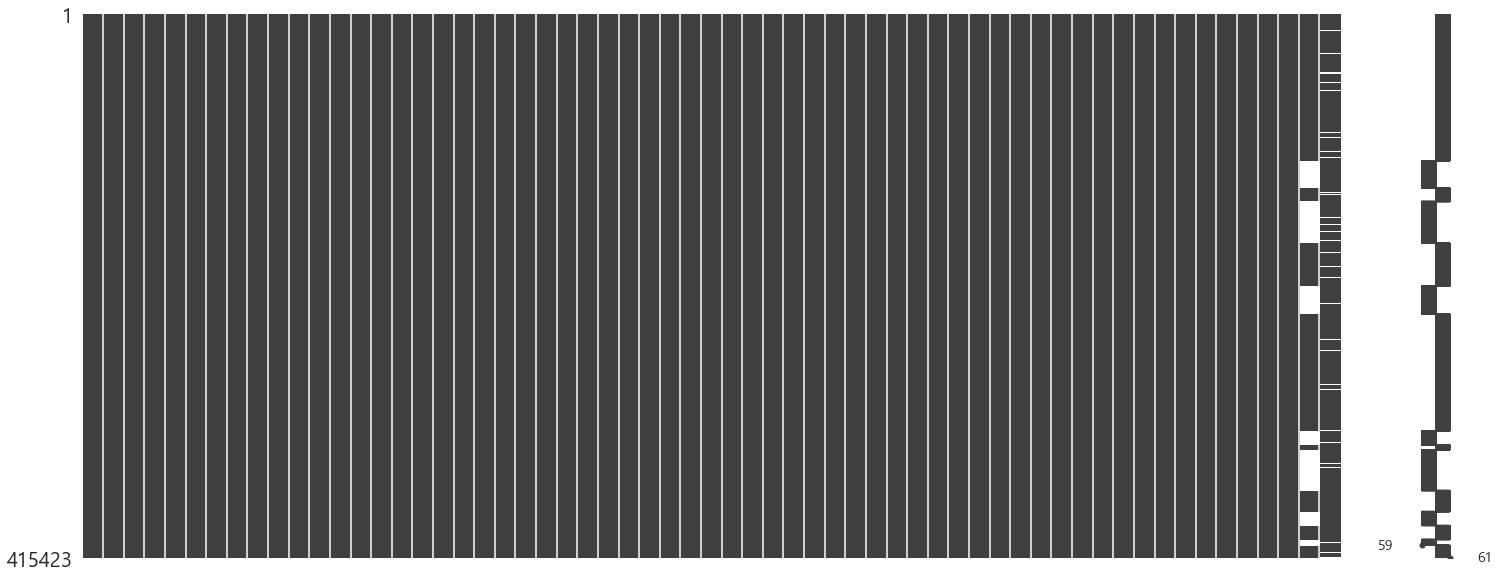

In [8]:
# Nan data 확인
missingno.matrix(train)
plt.show()

In [9]:
# 배차간격에 Nan값 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 61 columns):
bus_route_id        415423 non-null int64
bus_route_id_y      415423 non-null int64
date_day            415423 non-null int64
date_day_y          415423 non-null float64
date_dateofname     415423 non-null object
date_dayofname_y    415423 non-null object
date_dayofweek      415423 non-null int64
date_dayofweek_y    415423 non-null float64
date                415423 non-null datetime64[ns]
date_y              415423 non-null object
dis_jejusi_x        415423 non-null float64
dis_jejusi_y        415423 non-null float64
dis_seoquipo_x      415423 non-null float64
dis_seoquipo_y      415423 non-null float64
holiday_x           415423 non-null float64
holiday_y           415423 non-null float64
id_x                415423 non-null int64
in_out              415423 non-null int64
in_out_y            415423 non-null int64
index               415423 non-null int64
latitude_x          4

In [10]:
# 배차간격이 없는것은 너무오래 안다니는것으로 999로 변경
train['bus_interval'].fillna(999, inplace = True)
train['precipitation'].fillna(0, inplace = True)

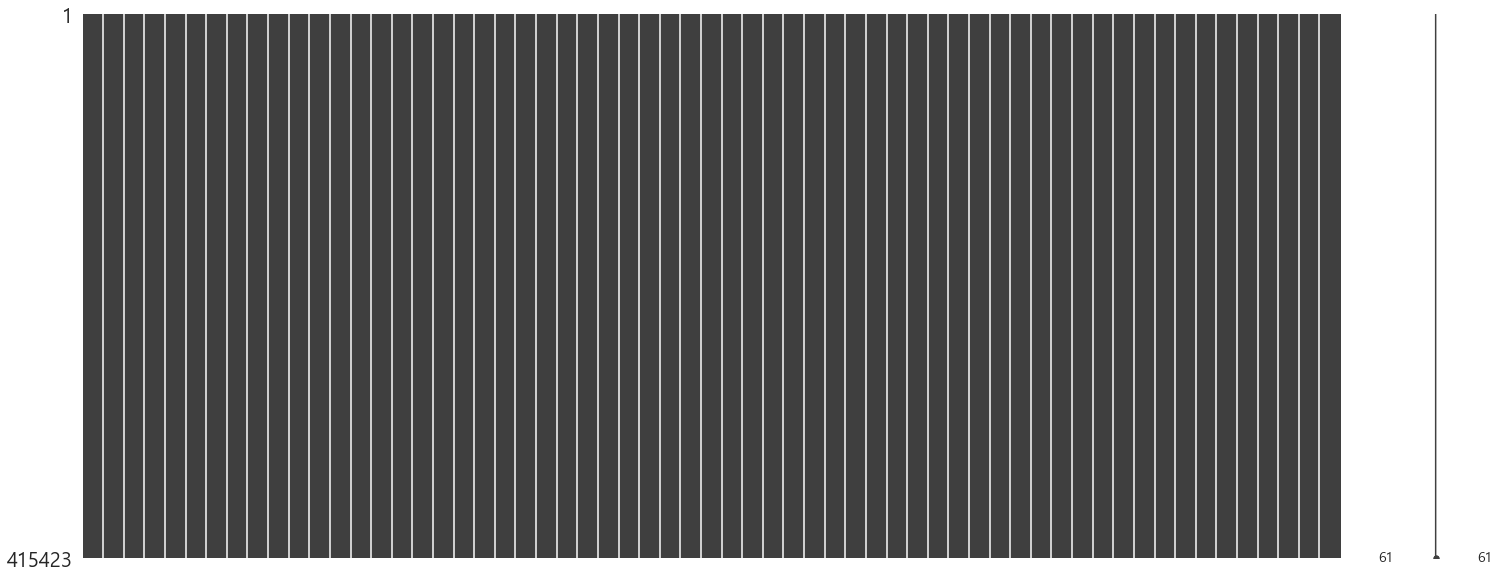

In [11]:
# Nan data 확인
missingno.matrix(train)
plt.show()

In [12]:
# 정확히 Nan값이 없는것을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 61 columns):
bus_route_id        415423 non-null int64
bus_route_id_y      415423 non-null int64
date_day            415423 non-null int64
date_day_y          415423 non-null float64
date_dateofname     415423 non-null object
date_dayofname_y    415423 non-null object
date_dayofweek      415423 non-null int64
date_dayofweek_y    415423 non-null float64
date                415423 non-null datetime64[ns]
date_y              415423 non-null object
dis_jejusi_x        415423 non-null float64
dis_jejusi_y        415423 non-null float64
dis_seoquipo_x      415423 non-null float64
dis_seoquipo_y      415423 non-null float64
holiday_x           415423 non-null float64
holiday_y           415423 non-null float64
id_x                415423 non-null int64
in_out              415423 non-null int64
in_out_y            415423 non-null int64
index               415423 non-null int64
latitude_x          4

In [13]:
# 시작 날짜와, 끝 날짜 확인
print(train['date'].min())
print(train['date'].max())
# date 타입 변경
# train['date'] = train['date'].astype('datetime64')
# 9월 1일 ~ 9월 30일 데이터이니까, day만 따로 가져옴
train['date_day'] = train['date'].dt.day
# 월(0) ~ 일(6) 데이터로 변환
train['date_dayofweek'] = train['date'].dt.dayofweek
train['date_dayofname']= train['date'].dt.day_name()
train[['date','date_dayofweek','date_day','date_dayofname']]

# 평일과 휴일의 원핫 인코딩
train.loc[train['date_dayofweek'] == 0, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 1, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 2, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 3, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 4, 'weekday' ] = 0
train.loc[train['date_dayofweek'] == 5, 'weekday' ] = 0
train.loc[train['date_dayofweek'] == 6, 'weekday' ] = 0

#Weekend 주말
train.loc[train['date_dayofweek'] == 0, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 1, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 2, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 3, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 4, 'weekend' ] = 1
train.loc[train['date_dayofweek'] == 5, 'weekend' ] = 1
train.loc[train['date_dayofweek'] == 6, 'weekend' ] = 1

# 추석 추가도 공휴일로 처리
train['holiday'] = 0
train.loc[train['date'] == '2019-09-14', 'holiday'] = 1
train.loc[train['date'] == '2019-09-13', 'holiday'] = 1
train.loc[train['date'] == '2019-09-12', 'holiday'] = 1

# 태풍의 컬럼 추가
train['typhoon'] = 0
train.loc[train['date'] == '2019-09-06', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-07', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-21', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-22', 'typhoon'] = 1

train.tail(2)

2019-09-01 00:00:00
2019-09-30 00:00:00


,bus_route_id,bus_route_id_y,date_day,date_day_y,date_dateofname,date_dayofname_y,date_dayofweek,date_dayofweek_y,date,date_y,dis_jejusi_x,dis_jejusi_y,dis_seoquipo_x,dis_seoquipo_y,holiday_x,holiday_y,id_x,in_out,in_out_y,index,latitude_x,latitude_y,longitude_x,longitude_y,off10_x,off10_y,off11_x,off11_y,off6_x,off6_y,off7_x,off7_y,off8_x,off8_y,off9_x,off9_y,ride10_x,ride10_y,ride11_x,ride11_y,ride18_x,ride18_y,ride6_x,ride6_y,ride7_x,ride7_y,ride8_x,ride8_y,ride9_x,ride9_y,route_id,station_code,station_code_y,station_name,city,addr,road_addr,weather_addr,temperature,precipitation,bus_interval,date_dayofname,weekday,weekend,holiday,typhoon
415421,29300000,29300000,30,0.0,Monday,0.0,0,0.0,2019-09-30,2019-09-30 00:00:00,27.536920,0.00000,17.698513,0.00000,0.0,0.0,410471,0,0,0,33.32477,0.0000,126.73157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2337,2337,이화농장,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3,15.0,Monday,1.0,0.0,0,0
415422,26060000,26050000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,24.935535,24.78379,5.492274,5.52953,0.0,0.0,406081,0,0,0,33.28732,33.2886,126.60693,126.60635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10000.0,1891,1890,서귀포농업기술센터,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3,67.0,Monday,1.0,0.0,0,0


In [14]:
# 시내, 시외 원핫 인코딩
in_out = pd.get_dummies(train['in_out'])
in_out.columns = ['in_', 'out']
train = pd.concat([train, in_out], axis = 1)
train.tail(2)

,bus_route_id,bus_route_id_y,date_day,date_day_y,date_dateofname,date_dayofname_y,date_dayofweek,date_dayofweek_y,date,date_y,dis_jejusi_x,dis_jejusi_y,dis_seoquipo_x,dis_seoquipo_y,holiday_x,holiday_y,id_x,in_out,in_out_y,index,latitude_x,latitude_y,longitude_x,longitude_y,off10_x,off10_y,off11_x,off11_y,off6_x,off6_y,off7_x,off7_y,off8_x,off8_y,off9_x,off9_y,ride10_x,ride10_y,ride11_x,ride11_y,ride18_x,ride18_y,ride6_x,ride6_y,ride7_x,ride7_y,ride8_x,ride8_y,ride9_x,ride9_y,route_id,station_code,station_code_y,station_name,city,addr,road_addr,weather_addr,temperature,precipitation,bus_interval,date_dayofname,weekday,weekend,holiday,typhoon,in_,out
415421,29300000,29300000,30,0.0,Monday,0.0,0,0.0,2019-09-30,2019-09-30 00:00:00,27.536920,0.00000,17.698513,0.00000,0.0,0.0,410471,0,0,0,33.32477,0.0000,126.73157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2337,2337,이화농장,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3,15.0,Monday,1.0,0.0,0,0,1,0
415422,26060000,26050000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,24.935535,24.78379,5.492274,5.52953,0.0,0.0,406081,0,0,0,33.28732,33.2886,126.60693,126.60635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10000.0,1891,1890,서귀포농업기술센터,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3,67.0,Monday,1.0,0.0,0,0,1,0


In [16]:
# 2시간 노선 만들기
train['ride67_x'] = train['ride6_x'] + train['ride7_x']
train['ride89_x'] = train['ride8_x'] + train['ride9_x']
train['ride1011_x'] = train['ride10_x'] + train['ride11_x']
train['off67_x'] = train['off6_x'] + train['off7_x']
train['off89_x'] = train['off8_x'] + train['off9_x']
train['off1011_x'] = train['off10_x'] + train['off11_x']

train['ride67_y'] = train['ride6_y'] + train['ride7_y']
train['ride89_y'] = train['ride8_y'] + train['ride9_y']
train['ride1011_y'] = train['ride10_y'] + train['ride11_y']
train['off67_y'] = train['off6_y'] + train['off7_y']
train['off89_y'] = train['off8_y'] + train['off9_y']
train['off1011_y'] = train['off10_y'] + train['off11_y']


train.tail(2)

,bus_route_id,bus_route_id_y,date_day,date_day_y,date_dateofname,date_dayofname_y,date_dayofweek,date_dayofweek_y,date,date_y,dis_jejusi_x,dis_jejusi_y,dis_seoquipo_x,dis_seoquipo_y,holiday_x,holiday_y,id_x,in_out,in_out_y,index,latitude_x,latitude_y,longitude_x,longitude_y,off10_x,off10_y,off11_x,off11_y,off6_x,off6_y,off7_x,off7_y,off8_x,off8_y,off9_x,off9_y,ride10_x,ride10_y,ride11_x,ride11_y,ride18_x,ride18_y,ride6_x,ride6_y,ride7_x,ride7_y,ride8_x,ride8_y,ride9_x,ride9_y,route_id,station_code,station_code_y,station_name,city,addr,road_addr,weather_addr,temperature,precipitation,bus_interval,date_dayofname,weekday,weekend,holiday,typhoon,in_,out,ride67_x,ride89_x,ride1011_x,off67_x,off89_x,off1011_x,ride67_y,ride89_y,ride1011_y,off67_y,off89_y,off1011_y
415421,29300000,29300000,30,0.0,Monday,0.0,0,0.0,2019-09-30,2019-09-30 00:00:00,27.536920,0.00000,17.698513,0.00000,0.0,0.0,410471,0,0,0,33.32477,0.0000,126.73157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2337,2337,이화농장,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3,15.0,Monday,1.0,0.0,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,26060000,26050000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,24.935535,24.78379,5.492274,5.52953,0.0,0.0,406081,0,0,0,33.28732,33.2886,126.60693,126.60635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10000.0,1891,1890,서귀포농업기술센터,서귀포시,남원읍,중산간동로,서귀포,24.3,6.3,67.0,Monday,1.0,0.0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
# 탑승의 총합 만들기
train['ride_sum'] = train['ride6_x'] + train['ride7_x'] + train['ride8_x'] + train['ride9_x'] + train['ride10_x'] + train['ride11_x']

In [18]:
# 하차의 총합만들기
train['off_sum'] = train['off6_x'] + train['off7_x'] + train['off8_x'] + train['off9_x'] + train['off10_x'] + train['off11_x']

In [20]:
# 일별, 정류장별 버스노선 갯수
station_table = pd.pivot_table(index=['station_code', 'date'],values='bus_route_id', data=train, aggfunc=len).reset_index()
station_table.columns = ['station_code', 'date', 'bus_route_id_sum']
train = pd.merge(train, station_table, how='left', on=['station_code', 'date'])

# 정류장별 버스노선의 갯수
station_table = pd.pivot_table(index=['station_code'],values='bus_route_id', data=train, aggfunc=len).reset_index()
station_table.columns = ['station_code', 'bus_route_id_all_sum']
train = pd.merge(train, station_table, how='left', on=['station_code'])

train.tail(10)

,bus_route_id,bus_route_id_y,date_day,date_day_y,date_dateofname,date_dayofname_y,date_dayofweek,date_dayofweek_y,date,date_y,dis_jejusi_x,dis_jejusi_y,dis_seoquipo_x,dis_seoquipo_y,holiday_x,holiday_y,id_x,in_out,in_out_y,index,latitude_x,latitude_y,longitude_x,longitude_y,off10_x,off10_y,off11_x,off11_y,off6_x,off6_y,off7_x,off7_y,off8_x,off8_y,off9_x,off9_y,ride10_x,ride10_y,ride11_x,ride11_y,ride18_x,ride18_y,ride6_x,ride6_y,ride7_x,ride7_y,ride8_x,ride8_y,ride9_x,ride9_y,route_id,station_code,station_code_y,station_name,city,addr,road_addr,weather_addr,temperature,precipitation,bus_interval,date_dayofname,weekday,weekend,holiday,typhoon,in_,out,ride67_x,ride89_x,ride1011_x,off67_x,off89_x,off1011_x,ride67_y,ride89_y,ride1011_y,off67_y,off89_y,off1011_y,ride_sum,off_sum,bus_route_id_sum_x,bus_route_id_all_sum_x,bus_route_id_sum_y,bus_route_id_all_sum_y
415413,28160000,28160000,30,0.0,Monday,0.0,0,0.0,2019-09-30,2019-09-30 00:00:00,29.132624,0.000000,19.641760,0.000000,0.0,0.0,407477,0,0,0,33.28218,0.00000,126.34914,0.00000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3229,3229,세계자동차제주박물관,서귀포시,안덕면,중산간서로1615번길,서귀포,24.3,6.3,30.0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,1,3,1,3
415414,31330000,31330000,30,0.0,Monday,0.0,0,0.0,2019-09-30,2019-09-30 00:00:00,31.978141,0.000000,34.304453,0.000000,0.0,0.0,412699,0,0,0,33.43854,0.00000,126.85867,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4061,4061,양수동입구,서귀포시,성산읍,금백조로,서귀포,24.3,6.3,4.0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,4,1,4
415415,28580000,28510000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,36.081368,36.053739,39.794258,39.820786,0.0,0.0,408515,0,0,0,33.46503,33.46570,126.90863,126.90842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70000.0,2620,2621,성산고입구삼거리,서귀포시,성산읍,일주동로,서귀포,24.3,6.3,5.0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1,5,1,5
415416,32640000,32640000,30,0.0,Monday,0.0,0,0.0,2019-09-30,2019-09-30 00:00:00,27.871495,0.000000,12.133912,0.000000,0.0,0.0,415227,0,0,0,33.26237,0.00000,126.42804,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3384,3384,중문게이트볼장,서귀포시,중문동,중산간서로,서귀포,24.3,6.3,97.0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,4,1,4
415417,25080000,30460000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,28.855590,28.858484,14.211386,14.227235,0.0,0.0,405992,0,0,0,33.25985,33.25988,126.40570,126.40553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5380000.0,2098,2099,색달,서귀포시,색달동,색달로,서귀포,24.3,6.3,95.0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2,8,2,8
415418,32070000,30460000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,28.855590,28.858484,14.211386,14.227235,0.0,0.0,414264,0,0,0,33.25985,33.25988,126.40570,126.40553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1610000.0,2098,2099,색달,서귀포시,색달동,색달로,서귀포,24.3,6.3,39.0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,2,8,2,8
415419,22180000,22190000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,29.792074,29.806015,33.723998,33.741846,0.0,0.0,400320,0,0,0,33.45255,33.45263,126.83808,126.83825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,2744,2745,차남동산,서귀포시,성산읍,중산간동로,서귀포,24.3,6.3,96.0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,3,1,3
415420,27620000,27610000,30,30.0,Monday,Monday,0,0.0,2019-09-30,2019-09-30 00:00:00,37.886467,37.882242,29.954838,29.956639,0.0,0.0,407056,0,0,0,33.

In [28]:
# 컬럼별 값들의 갯수는?
for i in train.columns:
    print('{}의 개수는 {}'.format(i, len(train[i].unique())))

bus_route_id의 개수는 613
bus_route_id_y의 개수는 608
date_day의 개수는 30
date_day_y의 개수는 31
date_dateofname의 개수는 7
date_dayofname_y의 개수는 8
date_dayofweek의 개수는 7
date_dayofweek_y의 개수는 7
date의 개수는 30
date_y의 개수는 30
dis_jejusi_x의 개수는 3654
dis_jejusi_y의 개수는 3405
dis_seoquipo_x의 개수는 3620
dis_seoquipo_y의 개수는 3365
holiday_x의 개수는 2
holiday_y의 개수는 2
id_x의 개수는 415423
in_out의 개수는 2
in_out_y의 개수는 2
index의 개수는 1
latitude_x의 개수는 3473
latitude_y의 개수는 3240
longitude_x의 개수는 4448
longitude_y의 개수는 4067
off10_x의 개수는 47
off10_y의 개수는 45
off11_x의 개수는 55
off11_y의 개수는 50
off6_x의 개수는 35
off6_y의 개수는 34
off7_x의 개수는 51
off7_y의 개수는 50
off8_x의 개수는 53
off8_y의 개수는 51
off9_x의 개수는 46
off9_y의 개수는 45
ride10_x의 개수는 66
ride10_y의 개수는 62
ride11_x의 개수는 69
ride11_y의 개수는 64
ride18_x의 개수는 170
ride18_y의 개수는 161
ride6_x의 개수는 47
ride6_y의 개수는 39
ride7_x의 개수는 80
ride7_y의 개수는 76
ride8_x의 개수는 78
ride8_y의 개수는 76
ride9_x의 개수는 66
ride9_y의 개수는 61
route_id의 개수는 978
station_code의 개수는 3563
station_code_y의 개수는 3562
station_name의 개수는 1961
city의 개수는 2
addr

In [31]:
# 415423 rows × 86 columns
train = train.sort_values('id_x').reset_index(drop = True)
train.shape

(415423, 86)

In [32]:
# # 데이터 저장
# 저장된 데이터를 드렸으니, 해당 행은 실행할 필요없습니다.
# train.to_csv('raw_train.csv',encoding='utf-8',index = False)